# Nearest Neighbors

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents we typically
  - Decide on a notion of similarity
  - Find the documents that are most similar 

In the assignment we will
  - Gain intuition for different notions of similarity and practice finding similar documents. 
  - Explore the tradeoffs with representing documents using raw word counts and TF-IDF
  - Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

**Note to Amazon EC2 users**: To conserve memory, make sure to stop all the other notebooks before running this notebook.

## Import necessary packages

As usual we need to first import the Python packages that we will need.

In [1]:
import turicreate
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Load Wikipedia dataset

We will be using the same dataset of Wikipedia pages that we used in the Machine Learning Foundations course (Course 1). Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [2]:
wiki = turicreate.SFrame('../data/people_wiki.sframe')
wiki.head(5)

URI,name,text
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...


In [3]:
wiki.shape

(59071, 3)

## Extract word count vectors

As we have seen in Course 1, we can extract word count vectors using a Turi Create utility function.  We add this as a column in `wiki`.

In [4]:
wiki['word_count'] = turicreate.text_analytics.count_words(wiki['text'])
wiki.head(3)

URI,name,text,word_count
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"{'melbourne': 1.0,'parade': 1.0, ..."
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"{'time': 1.0, 'each':1.0, 'hour': 1.0, ..."
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"{'society': 1.0,'hamilton': 1.0, 'to': ..."


## Find nearest neighbors

Let's start by finding the nearest neighbors of the Barack Obama page using the word count vectors to represent the articles and Euclidean distance to measure distance.  For this, again will we use a Turi Create implementation of nearest neighbor search.

In [5]:
model = turicreate.nearest_neighbors.create(wiki, label='name', 
                                            features=['word_count'], 
                                            method='brute_force', 
                                            distance='euclidean', 
                                            verbose=False)

model.summary()

Class                          : NearestNeighborsModel

Attributes
----------
Method                         : brute_force
Number of distance components  : 1
Number of examples             : 59071
Number of feature columns      : 1
Number of unpacked features    : 547979
Distance                       : euclidean
Total training time (seconds)  : 2.9169



Let's look at the top 10 nearest neighbors by performing the following query:

In [6]:
model.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=10, verbose=False)

query_label,reference_label,distance,rank
Barack Obama,Barack Obama,0.0,1
Barack Obama,Joe Biden,33.075670817082454,2
Barack Obama,George W. Bush,34.39476704383968,3
Barack Obama,Lawrence Summers,36.15245496505044,4
Barack Obama,Mitt Romney,36.16628264005025,5
Barack Obama,Francisco Barrio,36.3318042491699,6
Barack Obama,Walter Mondale,36.40054944640259,7
Barack Obama,Wynn Normington Hugh-Jones ...,36.49657518178932,8
Barack Obama,Don Bonker,36.6333181680284,9
Barack Obama,Andy Anstett,36.959437225152655,10


All of the 10 people are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians.

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.
* Wynn Normington Hugh-Jones is a former British diplomat and Liberal Party official.
* Andy Anstett is a former politician in Manitoba, Canada.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

For instance, let's find out why Francisco Barrio was considered a close neighbor of Obama.  To do this, let's look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages:

In [7]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    word_count_table = row[['word_count']].stack('word_count', new_column_name=['word','count'])
    return word_count_table.sort('count', ascending=False)

In [8]:
obama_words,  barrio_words = top_words('Barack Obama'), top_words('Francisco Barrio')
(obama_words, barrio_words)

(Columns:
 	word	str
 	count	float
 
 Rows: 273
 
 Data:
 +-------+-------+
 |  word | count |
 +-------+-------+
 |  the  |  40.0 |
 |   in  |  30.0 |
 |  and  |  21.0 |
 |   of  |  18.0 |
 |   to  |  14.0 |
 |  his  |  11.0 |
 | obama |  9.0  |
 |  act  |  8.0  |
 |   a   |  7.0  |
 |   he  |  7.0  |
 +-------+-------+
 [273 rows x 2 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 Columns:
 	word	str
 	count	float
 
 Rows: 225
 
 Data:
 +-----------+-------+
 |    word   | count |
 +-----------+-------+
 |    the    |  36.0 |
 |     of    |  24.0 |
 |    and    |  18.0 |
 |     in    |  17.0 |
 |     he    |  10.0 |
 |     to    |  9.0  |
 | chihuahua |  7.0  |
 |  governor |  6.0  |
 |     a     |  6.0  |
 |     as    |  5.0  |
 +-----------+-------+
 [225 rows x 2 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows an

In [9]:
type(obama_words)

turicreate.data_structures.sframe.SFrame

Let's extract the list of most frequent words that appear in both Obama's and Barrio's documents. We've so far sorted all words from Obama and Barrio's articles by their word frequencies. We will now use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the word column). See [the documentation](https://dato.com/products/create/docs/generated/graphlab.SFrame.join.html) for more details.

For instance, running
```
obama_words.join(barrio_words, on='word')
```
will extract the rows from both tables that correspond to the common words.

In [10]:
combined_words = obama_words.join(barrio_words, on='word', 
                                  alter_name={'count':'Barrio'}).rename({'count':'Obama'})
combined_words

word,Obama,Barrio
the,40.0,36.0
in,30.0,17.0
and,21.0,18.0
of,18.0,24.0
to,14.0,9.0
his,11.0,5.0
a,7.0,6.0
he,7.0,10.0
as,6.0,5.0
was,5.0,4.0


**Note**. The **join** operation does not enforce any particular ordering on the shared column. So to obtain, say, the five common words that appear most often in Obama's article, sort the combined table by the Obama column. Don't forget `ascending=False` to display largest counts first.

In [11]:
combined_words.sort('Obama', ascending=False)

word,Obama,Barrio
the,40.0,36.0
in,30.0,17.0
and,21.0,18.0
of,18.0,24.0
to,14.0,9.0
his,11.0,5.0
a,7.0,6.0
he,7.0,10.0
as,6.0,5.0
was,5.0,4.0


In [12]:
combined_words.sort('Obama', ascending=False).topk('Obama', 5)

word,Obama,Barrio
the,40.0,36.0
in,30.0,17.0
and,21.0,18.0
of,18.0,24.0
to,14.0,9.0


**Quiz Question**. Among the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?
  - cf. cell below

Hint:
* Refer to the previous paragraph for finding the words that appear in both articles. Sort the common words by their frequencies in Obama's article and take the largest five.
* Each word count vector is a Python dictionary. For each word count vector in SFrame, you'd have to check if the set of the 5 common words is a subset of the keys of the word count vector. Complete the function `has_top_words` to accomplish the task.
  - Convert the list of top 5 words into set using the syntax
```
set(common_words)
```
    where `common_words` is a Python list. See [this link](https://docs.python.org/2/library/stdtypes.html#set) if you're curious about Python sets.
  - Extract the list of keys of the word count dictionary by calling the [`keys()` method](https://docs.python.org/2/library/stdtypes.html#dict.keys).
  - Convert the list of keys into a set as well.
  - Use [`issubset()` method](https://docs.python.org/2/library/stdtypes.html#set) to check if all 5 words are among the keys.
* Now apply the `has_top_words` function on every row of the SFrame.
* Compute the sum of the result column to obtain the number of articles containing all the 5 top words.

In [13]:
def has_top_words(word_count_vector, 
                  common_words=set(combined_words.sort('Obama', ascending=False).topk('Obama', 5)['word'])):
    unique_words = set(word_count_vector.keys())  # extract the keys of word_count_vector and convert it to a set
    return common_words.issubset(unique_words)    # True if common_words is a subset of unique_words, False otherwise

In [14]:
wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)
sum(wiki['has_top_words'])  # use has_top_words column to answer the quiz question

56066

**Checkpoint**. Check your `has_top_words` function on two random articles:

In [15]:
assert has_top_words(wiki[32]['word_count'])  ## 'Correct output: True'
assert len(wiki[32]['word_count']) == 167     ## It should be 167

In [16]:
assert not has_top_words(wiki[33]['word_count'])  ## 'Correct output: False'
assert len(wiki[33]['word_count']) == 188         ## It should be 188

**Quiz Question**. Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?
  - cf. cell below. 
    ('George W. Bush, Joe Biden', 32.7566787083184)

Hints: 
* To compute the Euclidean distance between two dictionaries, use `turicreate.toolkits.distances.euclidean`. Refer to [this link](https://apple.github.io/turicreate/docs/api/generated/turicreate.toolkits.distances.euclidean.html) for usage.
* When using Boolean filter in SFrame/SArray, take the index 0 to access the first match. (Round your answer to three decimal places.)

In [17]:
Names = ["Barack Obama", "George W. Bush", "Joe Biden"]
pages = {}
for name in Names:
  pages[name] = wiki[wiki['name'] == name]['word_count'][0]
  
pages.keys()

dict_keys(['Barack Obama', 'George W. Bush', 'Joe Biden'])

In [18]:
import math

euc_dist = {}
for ix in range(len(Names)):
  for jx in range(ix + 1, len(Names)):
    name_s, name_d = Names[ix], Names[jx]
    euc_dist[f"{name_s}, {name_d}"] = turicreate.toolkits.distances.euclidean(pages[name_s], pages[name_d])

euc_dist

{'Barack Obama, George W. Bush': 34.39476704383968,
 'Barack Obama, Joe Biden': 33.075670817082454,
 'George W. Bush, Joe Biden': 32.7566787083184}

In [19]:
from functools import reduce

reduce(lambda md, d: d if d[1] < md[1] else md, euc_dist.items(), ("foo", math.inf))

('George W. Bush, Joe Biden', 32.7566787083184)

**Quiz Question**. Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page.

In [20]:
common_words_obama_bush = set(pages['Barack Obama']).intersection(set(pages['George W. Bush']))

sorted([(w, pages['Barack Obama'][w]) for w in common_words_obama_bush], key=lambda t: t[1], reverse=True)[:10]

[('the', 40.0),
 ('in', 30.0),
 ('and', 21.0),
 ('of', 18.0),
 ('to', 14.0),
 ('his', 11.0),
 ('act', 8.0),
 ('a', 7.0),
 ('he', 7.0),
 ('as', 6.0)]

**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

## TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons. 

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.  Let's use Turi Create's implementation of TF-IDF and repeat the search for the 10 nearest neighbors of Barack Obama:

In [21]:
wiki['tf_idf'] = turicreate.text_analytics.tf_idf(wiki['word_count'])

In [22]:
model_tf_idf = turicreate.nearest_neighbors.create(wiki, 
                                                   label='name', 
                                                   features=['tf_idf'],
                                                   method='brute_force', 
                                                   distance='euclidean',
                                                   verbose=False)

model_tf_idf.summary()

Class                          : NearestNeighborsModel

Attributes
----------
Method                         : brute_force
Number of distance components  : 1
Number of examples             : 59071
Number of feature columns      : 1
Number of unpacked features    : 547979
Distance                       : euclidean
Total training time (seconds)  : 2.0354



In [23]:
top_10_dist_from_obama = model_tf_idf.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=10, verbose=False)
top_10_dist_from_obama

query_label,reference_label,distance,rank
Barack Obama,Barack Obama,0.0,1
Barack Obama,Phil Schiliro,106.86101369140928,2
Barack Obama,Jeff Sessions,108.87167421571078,3
Barack Obama,Jesse Lee (politician),109.04569790902957,4
Barack Obama,Samantha Power,109.10810616502708,5
Barack Obama,Bob Menendez,109.78186710530215,6
Barack Obama,Eric Stern (politician),109.9577880796839,7
Barack Obama,James A. Guest,110.4138887175989,8
Barack Obama,Roland Grossenbacher,110.47060870018984,9
Barack Obama,Tulsi Gabbard,110.6969979988001,10


Let's determine whether this list makes sense.
* With a notable exception of Roland Grossenbacher, the other 8 are all American politicians who are contemporaries of Barack Obama.
* Phil Schiliro, Jesse Lee, Samantha Power, and Eric Stern worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document. Let us sort the words in Obama's article by their TF-IDF weights; we do the same for Schiliro's article as well.

In [24]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    word_count_table = row[['tf_idf']].stack('tf_idf', new_column_name=['word','weight'])
    return word_count_table.sort('weight', ascending=False)

In [25]:
obama_tf_idf = top_words_tf_idf('Barack Obama')
obama_tf_idf

word,weight
obama,43.2956530720749
act,27.67822262297991
iraq,17.747378587965535
control,14.887060845181308
law,14.722935761763422
ordered,14.533373950913514
military,13.115932778499415
involvement,12.784385241175055
response,12.784385241175055
democratic,12.410688697332166


In [26]:
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
schiliro_tf_idf

word,weight
schiliro,21.972990778450388
staff,15.856441635180534
congressional,13.547087656327776
daschleschiliro,10.986495389225194
obama,9.621256238238866
waxman,9.04058524016988
president,9.033586614158258
2014from,8.683910296231149
law,7.361467880881711
consultant,6.913104037247212


Using the **join** operation we learned earlier, try your hands at computing the common words shared by Obama's and Schiliro's articles. Sort the common words by their TF-IDF weights in Obama's document.

In [27]:
combined_words_tf_idf = obama_tf_idf.join(schiliro_tf_idf, on='word', 
                                          alter_name={'weight':'Schiliro'}).rename({'weight':'Obama'})

combined_words_tf_idf_obama_sorted_top10 = combined_words_tf_idf.sort('Obama', ascending=False)[['word','Obama']][:10]
combined_words_tf_idf_obama_sorted_top10

word,Obama
obama,43.2956530720749
law,14.722935761763422
democratic,12.410688697332166
senate,10.164288179703693
presidential,7.386955418904825
president,7.226869291326606
policy,6.095386282141427
states,5.473200989631017
office,5.2481728232196465
2011,5.107041270312876


The first 10 words should say: Obama, law, democratic, Senate, presidential, president, policy, states, office, 2011.

In [28]:
assert all(
  map(lambda t: t[0] == t[1], 
      zip(combined_words_tf_idf_obama_sorted_top10['word'],
          ['obama', 'law', 'democratic', 'senate', 'presidential', 'president', 'policy', 'states', 'office', '2011']))
)

**Quiz Question**. Among the words that appear in both Barack Obama and Phil Schiliro, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?
  - only 14, cf. cell below

In [29]:
common_words_t5 = set(combined_words_tf_idf_obama_sorted_top10['word'][:5])
common_words_t5

{'democratic', 'law', 'obama', 'presidential', 'senate'}

In [30]:
from functools import partial
has_top_words_ = partial(has_top_words, common_words=common_words_t5)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words_)
sum(wiki['has_top_words'] ) # use has_top_words column to answer the quiz question

14

Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Choosing metrics

You may wonder why Joe Biden, Obama's running mate in two presidential elections, is missing from the query results of `model_tf_idf`. <br />
Let's find out why. First, compute the distance between TF-IDF features of Obama and Biden.

**Quiz Question**. Compute the Euclidean distance between TF-IDF features of Obama and Biden. <br />
Recall: When using Boolean filter in SFrame/SArray, take the index 0 to access the first match. (Round your answer to three decimal places.)

In [45]:
Names_Tf_Idf = ["Barack Obama", "Joe Biden"]
pages_tf_idf = {}

for name in Names_Tf_Idf:
  pages_tf_idf[name] = wiki[wiki['name'] == name]['tf_idf'][0]

euc_dist_tf_idf_obama_biden = turicreate.toolkits.distances.euclidean(pages_tf_idf['Barack Obama'], pages_tf_idf['Joe Biden'])
round(euc_dist_tf_idf_obama_biden, 3)

123.297

In [ ]:
euc_dist_tf_idf_obama_biden = turicreate.toolkits.distances.euclidean(pages['Barack Obama'], pages['Joe Biden'])
round(euc_dist_tf_idf_obama_biden, 3)

The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [32]:
top_10_dist_from_obama

query_label,reference_label,distance,rank
Barack Obama,Barack Obama,0.0,1
Barack Obama,Phil Schiliro,106.86101369140928,2
Barack Obama,Jeff Sessions,108.87167421571078,3
Barack Obama,Jesse Lee (politician),109.04569790902957,4
Barack Obama,Samantha Power,109.10810616502708,5
Barack Obama,Bob Menendez,109.78186710530215,6
Barack Obama,Eric Stern (politician),109.9577880796839,7
Barack Obama,James A. Guest,110.4138887175989,8
Barack Obama,Roland Grossenbacher,110.47060870018984,9
Barack Obama,Tulsi Gabbard,110.6969979988001,10


But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones. Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page.

In [33]:
def compute_length(row):
    return len(row['text'].split(' '))

wiki['length'] = wiki.apply(compute_length) 

In [34]:
nearest_neighbors_euclidean = model_tf_idf.\
  query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=100, verbose=False).\
  join(wiki[['name', 'length']], on={'reference_label':'name'})

nearest_neighbors_euclidean.sort('rank')

query_label,reference_label,distance,rank,length
Barack Obama,Barack Obama,0.0,1,540
Barack Obama,Phil Schiliro,106.86101369140928,2,208
Barack Obama,Jeff Sessions,108.87167421571078,3,230
Barack Obama,Jesse Lee (politician),109.04569790902957,4,216
Barack Obama,Samantha Power,109.10810616502708,5,310
Barack Obama,Bob Menendez,109.78186710530215,6,220
Barack Obama,Eric Stern (politician),109.9577880796839,7,255
Barack Obama,James A. Guest,110.4138887175989,8,215
Barack Obama,Roland Grossenbacher,110.47060870018984,9,201
Barack Obama,Tulsi Gabbard,110.6969979988001,10,228


In [35]:
# nearest_neighbors_euclidean.sort('rank')

To see how these document lengths compare to the lengths of other documents in the corpus, let's make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

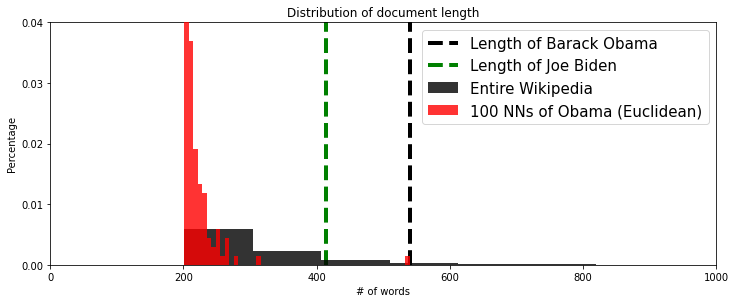

In [36]:
plt.figure(figsize=(10.5,4.5))

plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'][0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'][0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

Let us train a new nearest neighbor model, this time with cosine distances.  We then repeat the search for Obama's 100 nearest neighbors.

In [37]:
model2_tf_idf = turicreate.nearest_neighbors.create(wiki, 
                                                    label='name', 
                                                    features=['tf_idf'],
                                                    method='brute_force', 
                                                    distance='cosine',
                                                   verbose=False)

model2_tf_idf.summary()

Class                          : NearestNeighborsModel

Attributes
----------
Method                         : brute_force
Number of distance components  : 1
Number of examples             : 59071
Number of feature columns      : 1
Number of unpacked features    : 547979
Distance                       : cosine
Total training time (seconds)  : 2.1348



In [38]:
nearest_neighbors_cosine = model2_tf_idf.\
  query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=100, verbose=False).\
  join(wiki[['name', 'length']], on={'reference_label':'name'})

nearest_neighbors_cosine.sort('rank')

query_label,reference_label,distance,rank,length
Barack Obama,Barack Obama,2.220446049250313e-16,1,540
Barack Obama,Joe Biden,0.703138676733575,2,414
Barack Obama,Samantha Power,0.7429819023278823,3,310
Barack Obama,Hillary Rodham Clinton,0.7583583978869677,4,580
Barack Obama,Eric Stern (politician),0.7705612276009977,5,255
Barack Obama,Robert Gibbs,0.7846775047506501,6,257
Barack Obama,Eric Holder,0.7880390729434776,7,232
Barack Obama,Jesse Lee (politician),0.7909264153663162,8,216
Barack Obama,Henry Waxman,0.7983226028934735,9,279
Barack Obama,Joe the Plumber,0.799466360041952,10,217


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

Let's make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

<Figure size 756x324 with 0 Axes>

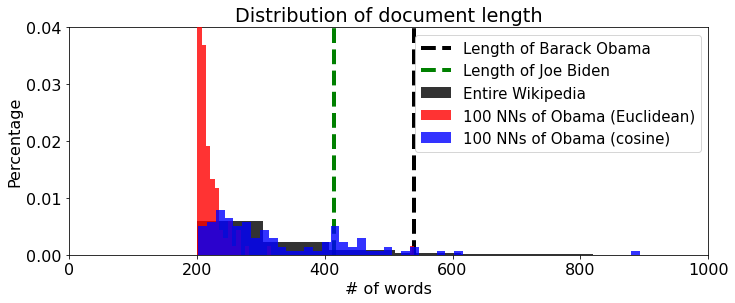

In [39]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'][0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'][0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

# Problem with cosine distances: tweets vs. long articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

How similar is this tweet to Barack Obama's Wikipedia article? Let's transform the tweet into TF-IDF features, using an encoder fit to the Wikipedia dataset.  (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.)

In [40]:
sf = turicreate.SFrame({'text': ['democratic governments control law in response to popular act']})
sf['word_count'] = turicreate.text_analytics.count_words(sf['text'])

encoder = turicreate.toolkits._feature_engineering.TFIDF(features=['word_count'], output_column_prefix='tf_idf')
encoder.fit(wiki)
sf = encoder.transform(sf)
sf

text,word_count,tf_idf.word_count
democratic governmentscontrol law in response ...,"{'act': 1.0, 'popular':1.0, 'in': 1.0, 'law': ...","{'act':3.4597778278724887, ..."


Let's look at the TF-IDF vectors for this tweet and for Barack Obama's Wikipedia entry, just to visually see their differences.

In [41]:
tweet_tf_idf = sf[0]['tf_idf.word_count']
tweet_tf_idf

{'act': 3.4597778278724887,
 'popular': 2.764478952022998,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'control': 3.721765211295327,
 'response': 4.261461747058352,
 'governments': 4.167571323949673,
 'to': 0.04694493768179923,
 'democratic': 3.1026721743330414}

In [42]:
obama = wiki[wiki['name'] == 'Barack Obama']
obama

Columns:
	URI	str
	name	str
	text	str
	word_count	dict
	has_top_words	int
	tf_idf	dict
	length	int

Rows: Unknown

Data:
+-------------------------------+--------------+-------------------------------+
|              URI              |     name     |              text             |
+-------------------------------+--------------+-------------------------------+
| <http://dbpedia.org/resour... | Barack Obama | barack hussein obama ii br... |
+-------------------------------+--------------+-------------------------------+
+-------------------------------+---------------+-------------------------------+
|           word_count          | has_top_words |             tf_idf            |
+-------------------------------+---------------+-------------------------------+
| {'normalize': 1.0, 'sought... |       1       | {'normalize': 10.293348208... |
+-------------------------------+---------------+-------------------------------+
+--------+
| length |
+--------+
|  540   |
+--------+
[? rows x 7 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.

Now, compute the cosine distance between the Barack Obama article and this tweet:

In [43]:
obama_tf_idf = obama[0]['tf_idf']
turicreate.toolkits.distances.cosine(obama_tf_idf, tweet_tf_idf)

0.7059183777794329

Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia 10 nearest neighbors:

In [44]:
model2_tf_idf.query(obama, label='name', k=10, verbose=False)

query_label,reference_label,distance,rank
Barack Obama,Barack Obama,2.220446049250313e-16,1
Barack Obama,Joe Biden,0.703138676733575,2
Barack Obama,Samantha Power,0.7429819023278823,3
Barack Obama,Hillary Rodham Clinton,0.7583583978869677,4
Barack Obama,Eric Stern (politician),0.7705612276009977,5
Barack Obama,Robert Gibbs,0.7846775047506501,6
Barack Obama,Eric Holder,0.7880390729434776,7
Barack Obama,Jesse Lee (politician),0.7909264153663162,8
Barack Obama,Henry Waxman,0.7983226028934735,9
Barack Obama,Joe the Plumber,0.799466360041952,10


With cosine distances, the tweet is "nearer" to Barack Obama than everyone else, except for Joe Biden!  This probably is not something we want. If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet? Ignoring article lengths completely resulted in nonsensical results. In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from _The Atlantic_, you wouldn't recommend him/her a tweet.